<a href="https://colab.research.google.com/github/RayendraNagata/API/blob/master/Covid_19_Fake_News_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Import Libraries

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout


In [ ]:
# Step 2: Load Dataset

In [ ]:
# Buat up file csv dari https://zenodo.org/records/4282522
from google.colab import files
uploaded = files.upload()

df = pd.read_csv('fake_or_real_covid.csv')
print(df.head())


Saving fake_or_real_covid.csv to fake_or_real_covid (1).csv
                                           headlines  outcome
0  A post claims compulsory vacination violates t...        0
1  A photo claims that this person is a doctor wh...        0
2  Post about a video claims that it is a protest...        0
3  All deaths by respiratory failure and pneumoni...        0
4  The dean of the College of Biologists of Euska...        0


In [ ]:
# Step 3: Preprocessing

In [ ]:
# Step 3: Preprocessing : buat bersihin teks dari karakter yang tidak perlu sblm digunakan untuk machine learning

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text): #fungsi clean_text u/ menerima teks sbg input
    text = re.sub(r'[^a-zA-Z]', ' ', text) # hanya ambil huruf
    text = text.lower() # ubah ke huruf kecil
    words = text.split() # pisah jadi list kata
    words = [w for w in words if not w in stop_words]
    return ' '.join(words) # Hapus stopword (kata nggak penting kayak "the", "and", "is")

df['clean_text'] = df['headlines'].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Step 4: Tokenization and Padding

# Tokenization --> mengubah teks menjadi angka
# padding --> memastikan semua input memiliki panjang yang sama

contoh tokenization

*   coronavirus: 1
*   china: 2
*   new: 3
*   virus: 4
*   spreading: 5
*   rapidly: 6
*   across: 7
*   globe: 8

Maka, teks "coronavirus china new virus spreading rapidly across globe" akan dikonversi menjadi urutan token: [1, 2, 3, 4, 5, 6, 7, 8]

contoh paddingnya,
misal di set angka 100 brarti jadi:

[0, 0, 0, ..., 0, 1, 2, 3, 4, 5, 6, 7, 8]

In [ ]:
# Step 4: Tokenization and Padding

tokenizer = Tokenizer(num_words=5000) # membatasi tokenizer untuk hanya menyimpan 5000 kata yang paling sering muncul dalam dataset
tokenizer.fit_on_texts(df['clean_text'])
X = tokenizer.texts_to_sequences(df['clean_text'])
X = pad_sequences(X, maxlen=100)
# Replace 'label' with the actual column name for your target variable
# For example if your target variable is in the 'outcome' column:
y = df['outcome'].values


In [ ]:
c     an baik pada data baru yang belum pernah dilihat sebelumnya, dan untuk menghindari overfitting (model terlalu "hafal")

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Step 6: Build LSTM Model

In [ ]:

model = Sequential()
model.add(Embedding(5000, 64, input_length=100))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


128/128 ━━━━━━━━━━━━━━━━━━━━ 24s 151ms/step - accuracy: 0.9301 - loss: 0.2901 - val_accuracy: 0.9554 - val_loss: 0.1770
Epoch 2/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 157ms/step - accuracy: 0.9534 - loss: 0.1696 - val_accuracy: 0.9598 - val_loss: 0.1182
Epoch 3/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 19s 147ms/step - accuracy: 0.9756 - loss: 0.0695 - val_accuracy: 0.9745 - val_loss: 0.0987
Epoch 4/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 147ms/step - accuracy: 0.9869 - loss: 0.0357 - val_accuracy: 0.9755 - val_loss: 0.1120
Epoch 5/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - accuracy: 0.9942 - loss: 0.0182 - val_accuracy: 0.9716 - val_loss: 0.1206


In [ ]:
# Step 7: Evaluation

64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1950
           1       0.69      0.67      0.68        91

    accuracy                           0.97      2041
   macro avg       0.84      0.83      0.83      2041
weighted avg       0.97      0.97      0.97      2041



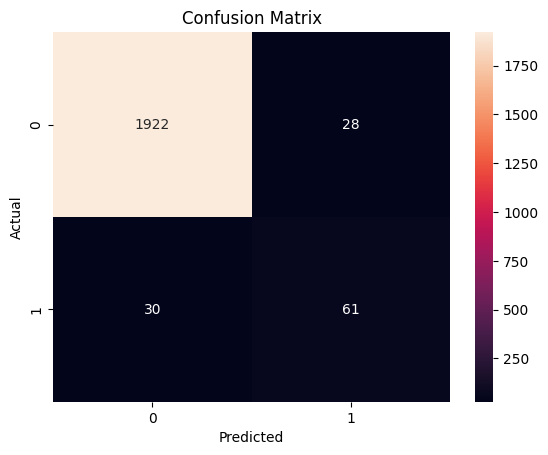

In [ ]:

y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
